#  This is Lab 3 executable file
This file contains the program code that is the solution to the tasks from the file [lab_3_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_3/lab_3_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [59]:
#Libraries initialization
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab


## Step 1.
Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [60]:
# Dataset initialization
path_to_file = '../Datasets/Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')

# Used features and data preparation
source_df = source_df[[ 'blueTotalHeal', # 1st target variable
                        'blueTotalGold', # 2nd target variable
                        'blueChampionDamageDealt', # 3rd target variable
                        'blueTotalMinionKills', # This and the rest are predictors
                        'blueWardPlaced',
                        'gameDuraton',
                        'blueWardkills', 
                        'blueKills', 
                        'blueDeath', 
                        'blueJungleMinionKills',
                        'blueObjectDamageDealt']]

source_df['blueChampionDamageDealt'] = source_df['blueChampionDamageDealt']/1000
source_df['blueObjectDamageDealt'] = source_df['blueObjectDamageDealt']/1000
source_df['blueTotalGold'] = source_df['blueTotalGold']/1000
source_df['blueTotalHeal'] = source_df['blueTotalHeal']/1000
source_df['blueTotalMinionKills'] = source_df['blueTotalMinionKills']/2
source_df['gameDuraton'] = source_df['gameDuraton']/60

# Removing outliers
for col_name in source_df:
    if True: # cut by quantiles
        # Default ones
        up_quant = 0.999
        down_quant = 0.001

        if col_name == 'blueTotalGold':
            down_quant = 0.005
        elif col_name == 'blueTotalMinionKills':
            down_quant = 0.005

        q_low = source_df[col_name].quantile(down_quant)
        q_hi  = source_df[col_name].quantile(up_quant)

        source_df = source_df[(source_df[col_name] < q_hi) & (source_df[col_name] > q_low)]
    else: # cut by zscore
        source_df[(np.abs(scipy.stats.zscore(source_df)) < 3).all(axis=1)]

targets_df = source_df.iloc[:, :3].copy()
predictors_df = source_df.iloc[:, 3:].copy()

print('Targets:')
targets_df.head(5)


Targets:


,blueTotalHeal,blueTotalGold,blueChampionDamageDealt
0,31.035,37.001,56.039
1,26.397,41.072,60.243
2,6.567,22.929,24.014
3,24.718,63.447,101.607
4,37.161,74.955,134.826


In [18]:
print('Predictors:')
predictors_df.head(5)

Predictors:


,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt
0,38,13,15,31,220.0,105,31.035,5.675
1,57,18,19,8,265.5,111,26.397,45.303
2,28,7,5,20,153.0,64,6.567,5.651
3,129,39,26,36,387.0,226,24.718,31.019
4,114,35,27,40,415.5,252,37.161,95.287


## Step 2.
Using univariate parametric distributions that were fitted in Lab#2 (or Lab#1) make sampling of chosen target variables. Use for this 2 different sampling methods.

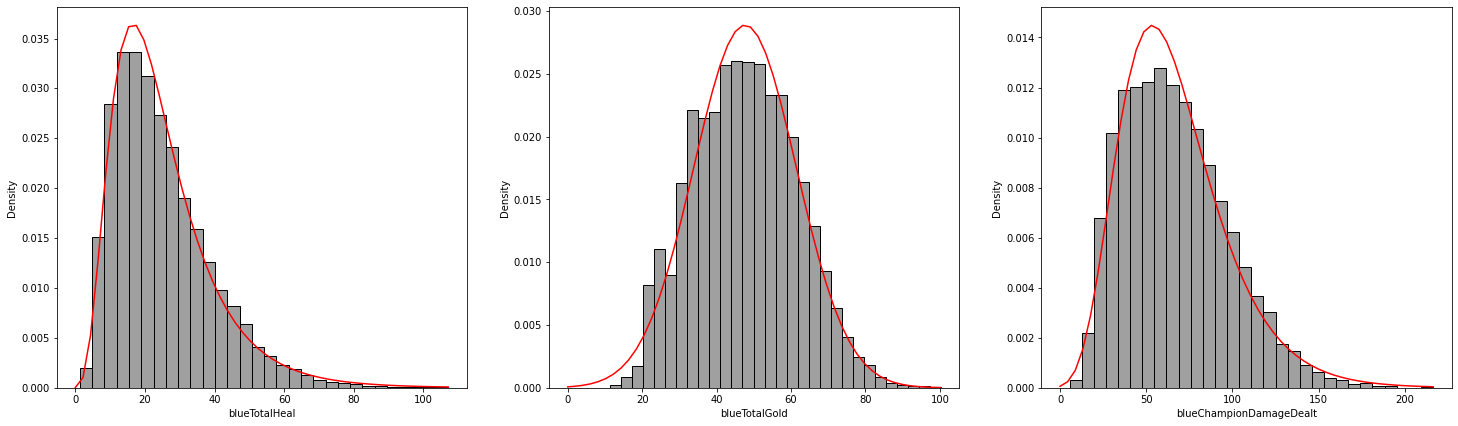

In [92]:
# Bring 3 target univariate parametric distributions from Lab 1
fig, axes = plt.subplots(1, 3, figsize=(25, 7))
for i, col_name in enumerate(targets_df):
    sns.histplot(source_df[col_name], kde=False, bins=30, stat='density', ax=axes[i], palette='Set3', color = 'grey')
    max_amount = targets_df[col_name].max()
    x = np.linspace(0, max_amount)

    if col_name == 'blueChampionDamageDealt' or col_name == 'blueTotalHeal':
        # The lognorm distribution parameters are determined using the fit function based on the maximum likelihood method
        mle_params = sp.stats.lognorm.fit(source_df[col_name], loc=1.1, scale=1.1) # Make initial Guess
        pdf_mle = sp.stats.lognorm.pdf(x, *mle_params)

    elif col_name == 'blueTotalGold':
        mle_params = sp.stats.norm.fit(source_df[col_name])
        pdf_mle = sp.stats.norm.pdf(x, *mle_params)
    
    axes[i].plot(x, pdf_mle, color='r')

<AxesSubplot:xlabel='blueChampionDamageDealt', ylabel='Density'>

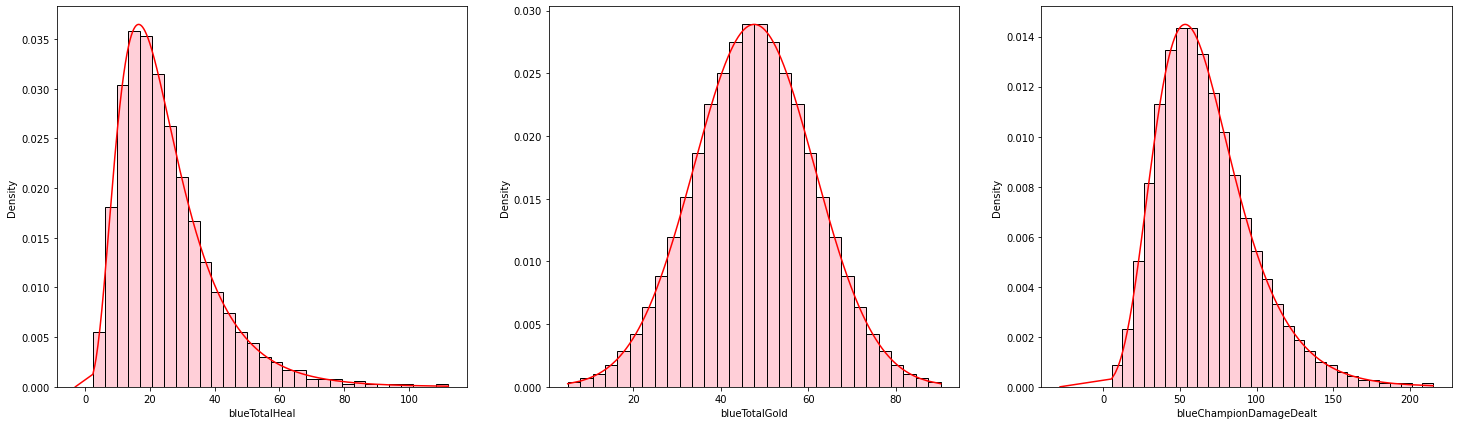

In [102]:
# Inverse transform sampling
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

params_1 = sp.stats.lognorm.fit(targets_df['blueTotalHeal'], loc=1.1, scale=1.1)
x = np.linspace(0, 100, 1000)
ppf_1 = sp.stats.lognorm.ppf(x / 100.0, *params_1)
pdf_1 = sp.stats.lognorm.pdf(ppf_1, *params_1)
axes[0].plot(ppf_1, pdf_1 , 'r')
axes[0].set(xlabel='blueTotalHeal')
synthetic_data=ppf_1[1:ppf_1.size-1]
sns.histplot(synthetic_data, kde=False, bins=30, stat='density', ax=axes[0], palette='Set3', color = 'pink')

params_2 = sp.stats.norm.fit(targets_df['blueTotalGold'])
x = np.linspace(0, 100, 1000)
ppf_2 = sp.stats.norm.ppf(x / 100.0, *params_2)
pdf_2 = sp.stats.norm.pdf(ppf_2, *params_2)
axes[1].plot(ppf_2, pdf_2 , 'r')
axes[1].set(xlabel='blueTotalGold')
synthetic_data=ppf_2[1:ppf_2.size-1]
sns.histplot(synthetic_data, kde=False, bins=30, stat='density', ax=axes[1], palette='Set3', color = 'pink')

params_3 = sp.stats.lognorm.fit(targets_df['blueChampionDamageDealt'], loc=1.1, scale=1.1)
x = np.linspace(0, 100, 1000)
ppf_3 = sp.stats.lognorm.ppf(x / 100.0, *params_3)
pdf_3 = sp.stats.lognorm.pdf(ppf_3, *params_3)
axes[2].plot(ppf_3, pdf_3 , 'r')
axes[2].set(xlabel='blueChampionDamageDealt')
synthetic_data=ppf_3[1:ppf_3.size-1]
sns.histplot(synthetic_data, kde=False, bins=30, stat='density', ax=axes[2], palette='Set3', color = 'pink')

[Text(0.5, 0, 'blueTotalGold'), Text(0, 0.5, 'Density')]

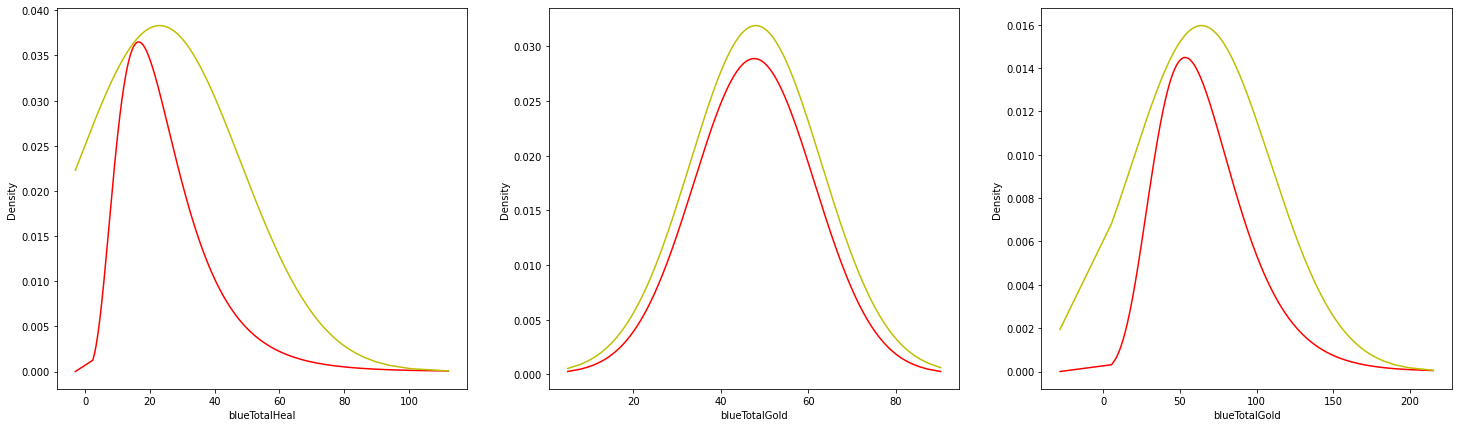

In [183]:
# Accept-Reject sampling

# Gaussian PDF
def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

# Lognormal PDF
def lognormal(x, s):
    return 1/(s*x*np.sqrt(2*np.pi)) * np.exp(-np.log(x)**2/(2*s**2))

fig, axes = plt.subplots(1, 3, figsize=(25, 7))

gaussian_1 = gaussian(ppf_1, 23, 25)
multiplier = 2.4
axes[0].plot(ppf_1, pdf_1 , 'r')
axes[0].plot(ppf_1, multiplier * gaussian_1 , 'y')
axes[0].set(xlabel='blueTotalHeal', ylabel='Density')

gaussian_2 = gaussian(ppf_2, 48, 15)
multiplier = 1.2
axes[1].plot(ppf_2, pdf_2 , 'r')
axes[1].plot(ppf_2, multiplier * gaussian_2 , 'y')
axes[1].set(xlabel='blueTotalGold', ylabel='Density')

gaussian_3 = gaussian(ppf_3, 64, 45)
multiplier = 1.8
axes[2].plot(ppf_3, pdf_3 , 'r')
axes[2].plot(ppf_3, multiplier * gaussian_3 , 'y')
axes[2].set(xlabel='blueTotalGold', ylabel='Density')

[Text(0.5, 0, 'blueTotalHeal'), Text(0, 0.5, 'Density')]

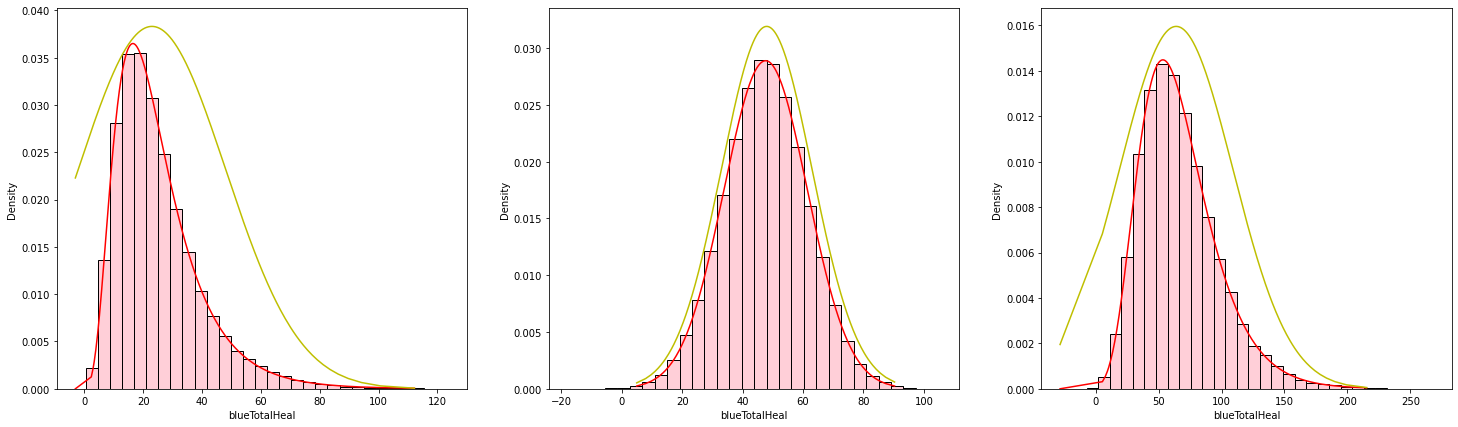

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

#number of instances
N = 100000
samples_1 = []
multiplier = 2.4
for _ in range(N):
    candidate = np.random.normal(23, 25)
    prob_accept = sp.stats.lognorm.pdf(candidate, *params_1) / (multiplier * gaussian(candidate, 23, 25))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples_1.append(candidate)

sns.histplot(samples_1, kde=False, bins=30, stat='density', ax=axes[0], palette='Set3', color = 'pink')
axes[0].plot(ppf_1, pdf_1 , 'r')
axes[0].plot(ppf_1, multiplier * gaussian_1 , 'y')
axes[0].set(xlabel='blueTotalHeal', ylabel='Density')

samples_2 = []
multiplier = 1.2
for _ in range(N):
    candidate = np.random.normal(48, 15)
    prob_accept = sp.stats.norm.pdf(candidate, *params_2) / (multiplier * gaussian(candidate, 48, 15))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples_2.append(candidate)

sns.histplot(samples_2, kde=False, bins=30, stat='density', ax=axes[1], palette='Set3', color = 'pink')
axes[1].plot(ppf_2, pdf_2 , 'r')
axes[1].plot(ppf_2, multiplier * gaussian_2 , 'y')
axes[1].set(xlabel='blueTotalHeal', ylabel='Density')

samples_3 = []
multiplier = 1.8
for _ in range(N):
    candidate = np.random.normal(64, 45)
    prob_accept = sp.stats.lognorm.pdf(candidate, *params_3) / (multiplier * gaussian(candidate, 64, 45))
    #accept with the calculated probability
    if np.random.random() < prob_accept:
        samples_3.append(candidate)

sns.histplot(samples_3, kde=False, bins=30, stat='density', ax=axes[2], palette='Set3', color = 'pink')
axes[2].plot(ppf_3, pdf_3 , 'r')
axes[2].plot(ppf_3, multiplier * gaussian_3 , 'y')
axes[2].set(xlabel='blueTotalHeal', ylabel='Density')

## Step 3.
Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients. 